# Cenaero

In [1]:
import numpy as np

In [2]:
# Constants

NUM_SEQUENCES = 121
DATA_PATH = '../data/38Q31TzlO-{}/npz_data/data.npz'
PARAMS_PATH = '../data/38Q31TzlO-{}/Minamo_Parameters-Wall2D.txt'

In [3]:
# Data loading and parsing methods

def load_data(simulation_ids, flatten_sequences=False):
    
    inputs, targets = [], []
    
    for simulation_id in simulation_ids:

        data = np.load(DATA_PATH.format(simulation_id))

        # Unused
        # T_top = data['T_top']
        # x = data['x']
        # y = data['y']
        # temperatures = data['temperatures']
        
        # Parse parameters
        with open(PARAMS_PATH.format(simulation_id)) as params_file:
            lines = params_file.read().splitlines()
            power = lines[0].split(' = ')[1]
            break_time = lines[1].split(' = ')[1]

        # Input data
        time = data['time']
        delta = time.copy()
        delta[1:] = time[1:] - time[:-1]
        laser_position = data['laser_position_x']
        laser_power = data['laser_power']
        power = np.full(laser_power.shape, power)
        break_time = np.full(laser_power.shape, break_time)
        input = np.stack([time, delta, laser_position, laser_power, power, break_time], axis=1)

        # Target data
        target = np.stack([data['T{}'.format(i + 1)] for i in range(6)], axis=1)

        inputs.append(input)
        targets.append(target)
    
    if flatten_sequences:
        inputs = np.concatenate(inputs, axis=0)
        targets = np.concatenate(targets, axis=0)
        
    else:
        max_len = max(input.shape[0] for input in inputs)
        
        for i, input in enumerate(inputs):
            inputs[i] = np.pad(input, [(0, max_len - input.shape[0]), (0, 0)])
        for i, target in enumerate(targets):
            targets[i] = np.pad(target, [(0, max_len - target.shape[0]), (0, 0)])
        
        inputs = np.stack(inputs, axis=1)
        targets = np.stack(targets, axis=1)
    
    return inputs, targets

In [4]:
# Preview of the data

inputs, targets = load_data(range(1, 8 + 1), flatten_sequences=False)

print('inputs:', inputs.shape)
print('targets:', targets.shape)

inputs: (1384, 8, 6)
targets: (1384, 8, 6)


## Train, test and validation split

In [5]:
np.random.seed(20210831)
permutation = np.random.permutation(np.arange(1, NUM_SEQUENCES + 1))
first_split = int(0.5 * NUM_SEQUENCES)
second_split = int(0.75 * NUM_SEQUENCES)
train_sequence_ids = permutation[:first_split]
eval_sequence_ids = permutation[first_split:second_split]
test_sequence_ids = permutation[second_split:]

In [6]:
train_inputs, train_targets = load_data(train_sequence_ids, flatten_sequences=True)
eval_inputs, eval_targets = load_data(eval_sequence_ids, flatten_sequences=True)
test_inputs, test_targets = load_data(test_sequence_ids, flatten_sequences=True)

## Models

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (8, 6)

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1)

In [9]:
rf.fit(train_inputs, train_targets)

RandomForestRegressor(n_jobs=-1)

In [10]:
eval_preds = rf.predict(eval_inputs)

In [11]:
mse_loss = ((eval_preds - eval_targets) ** 2).sum() / eval_preds.shape[0]
print(mse_loss)

20889.91209241639


#### Eval sample sequence

In [12]:
sample_eval_id = np.random.choice(eval_sequence_ids, size=(1,))
sample_eval_inputs, sample_eval_targets = load_data(sample_eval_id, flatten_sequences=True)

sample_eval_preds = rf.predict(sample_eval_inputs)

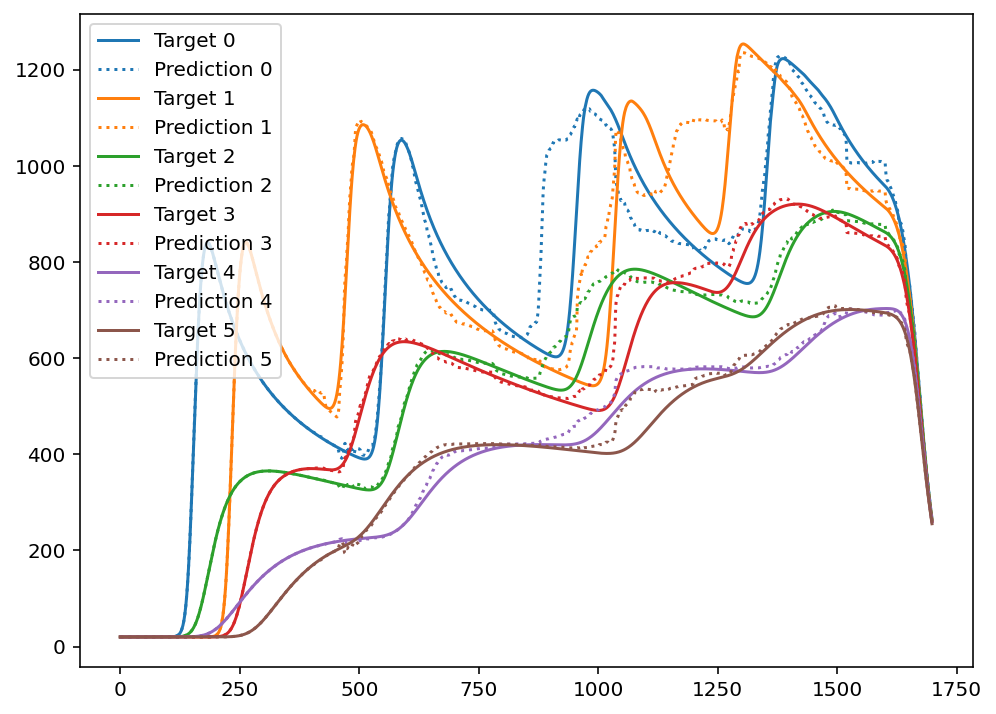

In [13]:
for i in range(6):
    plt.plot(sample_eval_targets[:, i], color='C{}'.format(i), label='Target {}'.format(i))
    plt.plot(sample_eval_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction {}'.format(i))
    plt.legend()

#### Train sample sequence

In [14]:
sample_train_id = np.random.choice(train_sequence_ids, size=(1,))
sample_train_inputs, sample_train_targets = load_data(sample_train_id, flatten_sequences=True)

sample_train_preds = rf.predict(sample_train_inputs)

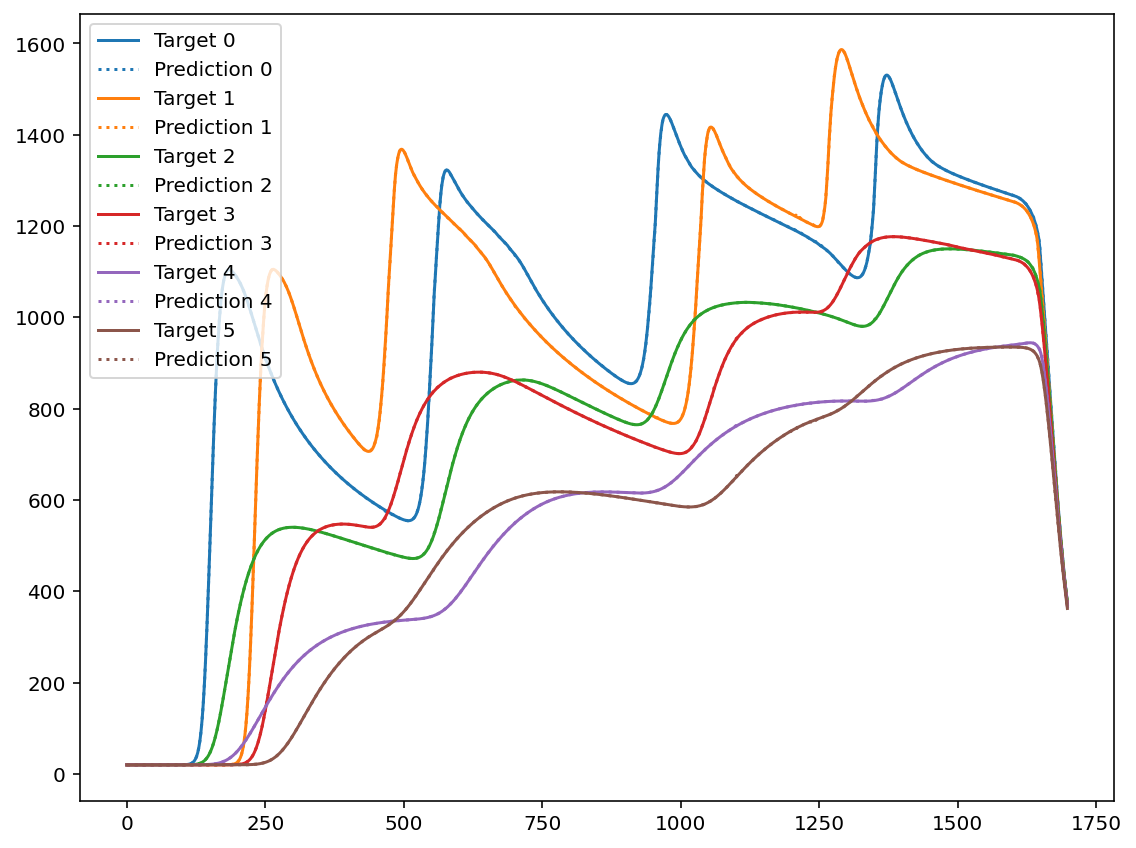

In [15]:
for i in range(6):
    plt.plot(sample_train_targets[:, i], color='C{}'.format(i), label='Target {}'.format(i))
    plt.plot(sample_train_preds[:, i], color='C{}'.format(i), linestyle=':', label='Prediction {}'.format(i))
    plt.legend()
plt.tight_layout()
plt.show()